This file include the implementation of other methods for SGM-FC

1. eigenmapping

2. raw SC

# Import some pkgs

In [2]:
import sys
sys.path.append("./mypkg")

import scipy

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
# 
from tqdm import trange
from scipy.io import loadmat
from functools import partial
from easydict import EasyDict as edict
from collections import defaultdict as ddict
from IPython.display import display
%load_ext autoreload
%autoreload 2

In [3]:
# my own fns
from brain import Brain
from FC_utils import build_fc_freq_m
from constants import RES_ROOT, DATA_ROOT, FIG_ROOT
from utils.misc import load_pkl, save_pkl
from utils.reparam import theta_raw_2out, logistic_np, logistic_torch
from utils.measures import reg_R_fn, lin_R_fn, lap_mat_fn
from sphere_utils import generate_spins, get_mid_pts, trans_spins

plt.style.use(FIG_ROOT/"base.mplstyle")

# Some fns

In [4]:
_minmax_vec = lambda x: (x-np.min(x))/(np.max(x)-np.min(x));

# minmax vec, but keep the sign
def _pn_minmax(vec):
    def _minmax_vec(x, miniv=None):
        if not isinstance(x, np.ndarray):
            x = np.array(x)
        x = x.astype(float)
        if np.max(x) == np.min(x):
            return x
        if miniv is None:
            miniv = np.min(x)
        return (x-miniv)/(np.max(x)-miniv)
    vec_copy = vec.copy()
    pvec = vec[vec>0]
    nvec = vec[vec<0]

    if len(pvec)>1:
        if pvec.std() < 1e-3:
            miniv = np.min(pvec) - (np.max(pvec) - np.min(pvec))/2
        else:
            miniv = np.min(pvec) - (np.max(pvec) - np.min(pvec))/10
        vec_copy[vec>0] = _minmax_vec(pvec, miniv=miniv)
    if len(nvec)>1:
        if nvec.std() < 1e-3:
            miniv = np.min(-nvec) - (np.max(-nvec) - np.min(-nvec))/2
        else:
            miniv = np.min(-nvec) - (np.max(-nvec) - np.min(-nvec))/10
        vec_copy[vec<0] = -_minmax_vec(-nvec, miniv=miniv)
    return vec_copy

_remove_norm = lambda x: x/np.linalg.norm(x)
_std_vec = lambda x: (x-np.mean(x))/np.std(x)
_remove_scale = _minmax_vec
uptri_idxs = np.triu_indices(68, k=1);
# transfer vec to a sym mat
def _vec_2mat(vec):
    mat = np.zeros((68, 68))
    mat[np.triu_indices(68, k = 1)] = vec
    mat = mat + mat.T
    return mat

In [5]:
def _get_base_metrics(fc, spins):
    """Get baseline mse via spin test
    """
    num_rep = len(spins)
    def _mse_err(ele1, ele2):
        fc1_c = _remove_scale(ele1)
        fc2_c = _remove_scale(ele2)
        return np.mean((fc1_c-fc2_c)**2)
    
    idxs = np.triu_indices_from(fc, k=1)
    eles = fc[idxs]
    eles_mm = _remove_scale(eles)
    
    metrics = edict()
    mses = []
    linrs = []
    regrs = []
    for ix in range(num_rep):
        spin_idxs = spins[ix]
        fc_spin = fc.copy()[spin_idxs][:, spin_idxs]
        spin_eles = fc_spin[idxs]
        spin_eles_mm = _remove_scale(spin_eles)
        mses.append(np.mean((spin_eles_mm-eles_mm)**2))
        linrs.append(lin_R_fn(spin_eles_mm.reshape(1, -1), 
                              eles_mm.reshape(1, -1))[0])
        regrs.append(reg_R_fn(spin_eles_mm.reshape(1, -1), 
                              eles_mm.reshape(1, -1))[0])
    metrics.mse = [np.mean(mses), np.std(mses)]
    metrics.linr = [np.mean(linrs), np.std(linrs)]
    metrics.regr = [np.mean(regrs), np.std(regrs)]
    return metrics

In [6]:
from scipy.stats import kendalltau
from scipy.stats import spearmanr

def divide_fc(fc):
    """Divide the FC into three blocks and vectorize them
    """
    size_fc = len(fc)
    hs_fc = int(size_fc/2)
    fc_block1 = fc[:hs_fc, :hs_fc]
    fc_block2 = fc[hs_fc:, hs_fc:];
    fc_block3 = fc[:hs_fc, hs_fc:];
    vec1 = _remove_scale(fc_block1[np.triu_indices(hs_fc, k = 1)])
    vec2 = _remove_scale(fc_block2[np.triu_indices(hs_fc, k = 1)])
    vec3 = _remove_scale(fc_block3.flatten())
    return vec1, vec2, vec3

def cal_metrics(fc1, fc2):
    """Calculate the distance between fc1 and fc2, including
        1. geodesic dist
        2. pearson's R
        3. lin R
        4. pearson's R after divide the FC into three blocks
        5. lin R after divide the FC into three blocks
    """
    fc1 = fc1.astype(np.float64)
    fc2 = fc2.astype(np.float64)
    size_fc = len(fc1)
    
    fc1_c = _remove_scale(fc1[np.triu_indices(size_fc, k=1)]).reshape(1, -1)
    fc2_c = _remove_scale(fc2[np.triu_indices(size_fc, k=1)]).reshape(1, -1)
    
    # all metrics
    reg_r = reg_R_fn(fc1_c, fc2_c)
    lin_r = lin_R_fn(fc1_c, fc2_c)
    mse = np.mean((fc1_c-fc2_c)**2)
    tau_r = kendalltau(fc1_c.reshape(-1), fc2_c.reshape(-1))[0]
    sp_r = spearmanr(fc1_c.reshape(-1), fc2_c.reshape(-1))[0]
    
    # block wise metrics
    blocks1 = divide_fc(fc1)
    blocks2 = divide_fc(fc2)
    reg_r_block = [reg_R_fn(vec1.reshape(1, -1), vec2.reshape(1, -1))[0] 
                   for vec1, vec2 in zip(blocks1, blocks2)]
    lin_r_block = [lin_R_fn(vec1.reshape(1, -1), vec2.reshape(1, -1))[0] 
                   for vec1, vec2 in zip(blocks1, blocks2)]
    
    res = edict()
    res.reg_r = reg_r[0]
    res.lin_r = lin_r[0]
    res.tau_r = tau_r
    res.sp_r = sp_r 
    res.mse = mse
    res.reg_r_block = np.mean(reg_r_block)
    res.lin_r_block = np.mean(lin_r_block)
    return res

def cal_metrics_batch(fc1s, fc2s):
    """fc1s, fc2s: num_fc x 68 x 68
    """
    ress = ddict(list)
    for ix in range(len(fc1s)):
        fc_t = fc2s[ix]
        fc_e = fc1s[ix]
        res = cal_metrics(fc_t, fc_e)
        for key, v in res.items():
            ress[key].append(v)
    
    return ress

# Load data and params

In [7]:
# for spin test
import nibabel as nib

# load data 
# left
surface = nib.freesurfer.read_geometry(DATA_ROOT/'fs_data/lh.pial')
sphere = nib.freesurfer.read_geometry(DATA_ROOT/'fs_data/lh.sphere')
lh_vers= surface[0]  
lh_faces = surface[1];  
lh_vers_sph = sphere[0];
lh_labs = nib.freesurfer.read_annot(DATA_ROOT/'fs_data/lh.aparc.annot');

# right 
surface = nib.freesurfer.read_geometry(DATA_ROOT/'fs_data/rh.pial')
sphere = nib.freesurfer.read_geometry(DATA_ROOT/'fs_data/rh.sphere')
rh_vers= surface[0]  
rh_faces = surface[1];  
rh_vers_sph = sphere[0];
rh_labs = nib.freesurfer.read_annot(DATA_ROOT/'fs_data/rh.aparc.annot');


# the order of my ROI
my_roi_labs = np.loadtxt(DATA_ROOT/"rois_order.txt", dtype=str);

lh_my_labs = np.array([ix.split("_L")[0].lower() for ix in my_roi_labs[:34]]);
lh_sph_labs = np.array([ix.decode('ascii') for ix in lh_labs[-1]]);
rh_my_labs = np.array([ix.split("_R")[0].lower() for ix in my_roi_labs[34:68]]);
rh_sph_labs = np.array([ix.decode('ascii') for ix in rh_labs[-1]]);


rh_mid_pts = get_mid_pts(rh_vers_sph, rh_labs[0]);
lh_mid_pts = get_mid_pts(lh_vers_sph, lh_labs[0]);


spins_raw = generate_spins(points_lh=lh_mid_pts, 
                       points_rh=rh_mid_pts, 
                       unique=True, 
                       n_rep=1000);

spins_lh = trans_spins(spins_raw["lh"], lh_sph_labs, lh_my_labs);
spins_rh = trans_spins(spins_raw["rh"], rh_sph_labs, rh_my_labs);
spins = np.concatenate([spins_lh, spins_rh+34], axis=-1);
spins = spins.astype(int);

In [8]:
paras = edict()
paras.bds = ["delta", "theta", "alpha", "beta_l"]
#paras.bds = ["alpha"]
paras.allbds = ["delta", "theta", "alpha", "beta_l"]
paras.add_v = 0.01
paras.nepoch = 100

In [9]:
# get time series
ind_ts_xr = xr.open_dataarray(DATA_ROOT/'meg_individual_tseries_reordered.nc')
ind_ts = ind_ts_xr.values;
ind_ts[:, :, :].shape;

In [10]:
# em FC
fc_root = RES_ROOT/"emp_fcs2"
def _get_fc(sub_ix, bd):
    fil = list(fc_root.rglob(f"*{bd}*{paras.nepoch}/sub{sub_ix}.pkl"))[0]
    return np.abs(load_pkl(fil, verbose=False))

In [11]:
# fc from NMM
def _get_nmm_fc(sub_ix, bd):
    nmm_fc_root = RES_ROOT/(f"rawfc2_NMM_{bd}_ep{paras.nepoch}_"
                            f"losslinr_addv{paras.add_v*100:.0f}")
    fil = list(nmm_fc_root.glob(f"ind{sub_ix}.pkl"))[0]
    return np.abs(load_pkl(fil, verbose=False))

In [12]:

def _add_v2con(cur_ind_conn, add_v):
    cur_ind_conn = cur_ind_conn.copy()
    add_v = np.quantile(cur_ind_conn, 0.99)*add_v # tuning 0.1
    np.fill_diagonal(cur_ind_conn[:34, 34:68], np.diag(cur_ind_conn[:34, 34:68]) + add_v)
    np.fill_diagonal(cur_ind_conn[34:68, :34], np.diag(cur_ind_conn[34:68, :34]) + add_v)
    np.fill_diagonal(cur_ind_conn[68:77, 77:], np.diag(cur_ind_conn[68:77, 77:]) + add_v)
    np.fill_diagonal(cur_ind_conn[77:, 68:77], np.diag(cur_ind_conn[77:, 68:77]) + add_v)
    return cur_ind_conn


In [13]:
# SC
ind_conn_xr = xr.open_dataarray(DATA_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values;

scs = []
for cur_ind_idx in range(36):
    # create spectrome brain:
    brain = Brain.Brain()
    brain.add_connectome(DATA_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
     # re-assign connectome to individual connectome
    brain.connectome =  _add_v2con(ind_conn[:, :, cur_ind_idx], paras.add_v)
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    sc = brain.reducedConnectome
    scs.append(sc[:68, :68])
scs = np.array(scs)
scs.shape

(36, 68, 68)

In [14]:
base_mses = ddict(list)
base_linrs = ddict(list)
base_regrs = ddict(list)
for band in paras.bds:
    for sub_ix in trange(36, desc=f"{band}"):
        metrics = _get_base_metrics(_get_fc(sub_ix, band), spins) 
        base_mses[band].append(metrics.mse)
        base_linrs[band].append(metrics.linr)
        base_regrs[band].append(metrics.regr)

beta_l: 100%|████████████████████████████████████████████████████████████████████| 36/36 [00:06<00:00,  5.64it/s]


In [16]:
# check the base results
# note that I only shuffle data, so LinR = regR
name_list = ["RegR", "MSE", "LinR"]
for idx, base_res in enumerate([base_regrs, base_mses, base_linrs]):
    for band in ["delta", "theta", "alpha", "beta_l"]:
        print(name_list[idx], band, np.mean(base_res[band], axis=0))

RegR delta [0.10661461 0.07424451]
RegR theta [0.1013717 0.07357  ]
RegR alpha [0.10254623 0.07416458]
RegR beta_l [0.09775077 0.07428369]
MSE delta [0.08863468 0.00739112]
MSE theta [0.08798725 0.00722323]
MSE alpha [0.08625801 0.00714327]
MSE beta_l [0.08414795 0.00693359]
LinR delta [0.10661461 0.07424451]
LinR theta [0.1013717 0.07357  ]
LinR alpha [0.10254623 0.07416458]
LinR beta_l [0.09775077 0.07428369]


# Eigenmapping

In [17]:
from scipy.optimize import minimize
class EigMapping():
    """Do eigenmapping approx from SC to FC.
       lamnew = exp(-lam(SC)*p1)+p2 from ben
    """
    def __init__(self, sc, init_ps, rescale_fn=lambda x: x):
        """args:
            sc: the SC matrix
            init_ps: Initial guess of the parameters, a list of two
            rescale_fn: The fn for rescale fc, default is the identity, minmax does not converge.
        """
        
        self.init_ps = init_ps
        #sc = np.diag(1/np.sum(sc, axis=0)) @ sc
        self.eigvals, self.eigvecs = self._get_eigres(sc)
        self.rescale_fn = rescale_fn
        self.opt_ps = None
         
    def _get_eigres(self, sc):
        eigvals, eigvecs = np.linalg.eig(sc);
        sort_idxs = np.argsort(-np.abs(eigvals))
        eigvals, eigvecs = eigvals[sort_idxs], eigvecs[:, sort_idxs]
        return eigvals, eigvecs
        
    def _recon_fc(self, ps=None):
        p1, p2 = ps
        new_eigvals = np.exp(-p1*self.eigvals/np.median(self.eigvals))+p2
        # note that for an ordinary matrix, it should be Ulam U^-1
        #rec_fc = self.eigvecs @ np.diag(new_eigvals) @ np.linalg.inv(self.eigvecs)
        rec_fc = self.eigvecs @ np.diag(new_eigvals) @ self.eigvecs.T
        return rec_fc - np.diag(np.diag(rec_fc))
    
    def opt(self, fc):
        def fun(ps):
            newfc = self._recon_fc(ps)
            idxs = np.triu_indices_from(newfc, k=1)
            return -lin_R_fn(self.rescale_fn(fc[idxs]), self.rescale_fn(newfc[idxs]))[0]
            #return np.mean((self.rescale_fn(fc[idxs])-
            #                self.rescale_fn(newfc[idxs]))**2)
        res = minimize(fun, self.init_ps, bounds= ((0, 1000), (-1000, 1000)), 
                      options=dict(disp=False))
        self.opt_ps = res.x
        if not res.success:
            print(f"May not converge, {res.message}.")
            
    def get_optfc(self, fc):
        if self.opt_ps is None:
            self.opt(fc)
        return self._recon_fc(self.opt_ps)

In [18]:
estfcs_eig = edict()
band = "delta"
for band in paras.bds:
    tmp= []
    for sub_ix in trange(scs.shape[0], desc=f"{band}"):
        opt = EigMapping(scs[sub_ix], [0, 0]) 
        curfc = _get_fc(sub_ix, band)
        tmp.append(opt.get_optfc(curfc));
    estfcs_eig[band] = np.array(tmp)

delta:   0%|                                                                              | 0/36 [00:00<?, ?it/s]

beta_l: 100%|████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.10it/s]


# Compare all methods

In [ ]:
def _get_metric_std(df, base_mse, base_linr, base_regr):
    base_mse = np.array(base_mse)
    base_linr = np.array(base_linr)
    base_regr = np.array(base_regr)
    df["mse_std"] = (df["mse"] - base_mse[:, 0])/base_mse[:, 1]
    df["lin_r_std"] = (df["lin_r"] - base_linr[:, 0])/base_linr[:, 1]
    df["reg_r_std"] = (df["reg_r"] - base_regr[:, 0])/base_regr[:, 1]
    return df

key_names = ['mse', 'lin_r', 'reg_r', "mse_std", 'lin_r_std',  "reg_r_std"]
method_names = [
                "SGM-SBI", 
                "SGM-SBI-shared", 
                "NMM",
                "Eigen",
                "Direct", 
                ]
band_res = edict()
for band in paras.allbds:
    sbi_ann_res = load_pkl(RES_ROOT/(f"rawfc2_SBIxANNBW_{band}_"
                                     f"ep{paras.nepoch}_"
                                     f"num1000_densitynsf_MR3_noise_sd120_"
                                     f"addv{paras.add_v*100:.0f}"
                                     f"/inf_res.pkl"), verbose=False);
    sbi_ann_ab_res = load_pkl(RES_ROOT/(f"rawfc2allbd_SBIxANNALLBD_"
                                        f"{'-'.join(paras.allbds)}_"
                                        f"ep{paras.nepoch}_"
                                        f"num1000_densitynsf_MR3_noise_sd120_"
                                        f"addv{paras.add_v*100:.0f}"
                                        f"/inf_res.pkl"), verbose=False);
    empfcs = np.array([_get_fc(sub_ix, band) for sub_ix in range(36)]);
    
    fcss = edict()
    fcss["SGM-SBI"] = np.array([np.abs(est_FC) for est_FC in sbi_ann_res.est_FCs]);
    fcss["SGM-SBI-shared"]= np.array([np.abs(est_FC) for est_FC in sbi_ann_ab_res[f"est_FCs_{band}"]])
    fcss["NMM"] = np.array([_get_nmm_fc(sub_ix, band) for sub_ix in range(36)]);
    fcss["Direct"] = scs
    fcss["Eigen"] = estfcs_eig[band]
    
    ress = edict()
    ress_full = edict()
    for key in method_names:
        tres =  pd.DataFrame(cal_metrics_batch(fcss[key], empfcs));
        ress_full[key] = tres
        ress[key] = _get_metric_std(tres, 
                                    base_mses[band], 
                                    base_linrs[band], 
                                    base_regrs[band]).mean()[key_names]
    
    out_df = pd.DataFrame(ress).T
    print(f"Results of {band}")
    display(out_df)
    band_res[band] = ress_full

# plot

## Violinplot

In [30]:
import matplotlib.cm as cm
import matplotlib 
#cmap = cm.get_cmap("tab10");
cmap = matplotlib.colormaps.get_cmap("tab10")
all_methods = [
                "SGM-SBI", 
                "SGM-SBI-shared", 
                "NMM",
                "Eigen",
                "Direct"];
cols = cmap(np.linspace(0, 1, len(all_methods)));
method_cols = {m:v for m, v in zip(all_methods, cols)};

# standard name
metric_names_plot = [
                "Standardized MSE", 
                "Standardized Lin's Corr", 
                "Standardized Pearson's Corr", 
                "MSE", 
                "Lin's Corr", 
                "Pearson's Corr"]
bands_name = [
    "Delta", "Theta", "Alpha", "Beta"
]

['Delta', 'Theta', 'Alpha', 'Beta']

In [31]:
method_names = [
                "SGM-SBI", 
                "SGM-SBI-shared", 
                "NMM",
                "Eigen",
                "Direct"]
metric_names = ['mse_std', 'lin_r_std', 'reg_r_std', "mse", "lin_r", "reg_r"]
df_plots = []
for band in paras.allbds:
    ress_full = band_res[band]
    df_plot = pd.concat([ress_full[key] for key in method_names]);
    df_plot["Method"] = np.concatenate([
        [key] * 36 for key in method_names
    ])
    df_plot["Band"] = [band] * df_plot.shape[0]
    df_plots.append(df_plot)
df_plots = pd.concat(df_plots);

In [32]:
def _pval_fn(pval):
    if pval < 0.001:
        return "**"
    elif pval < 0.05:
        return "*"
    else: 
        return None

In [33]:

pval_matss = {}
for band in paras.allbds:
    sbi_ann_res = load_pkl(RES_ROOT/(f"rawfc2_SBIxANNBW_{band}_"
                                     f"ep{paras.nepoch}_"
                                     f"num1000_densitynsf_MR3_noise_sd120_"
                                     f"addv{paras.add_v*100:.0f}"
                                     f"/inf_res.pkl"), verbose=False);
    sbi_ann_ab_res = load_pkl(RES_ROOT/(f"rawfc2allbd_SBIxANNALLBD_"
                                        f"{'-'.join(paras.allbds)}_"
                                        f"ep{paras.nepoch}_"
                                        f"num1000_densitynsf_MR3_noise_sd120_"
                                        f"addv{paras.add_v*100:.0f}"
                                        f"/inf_res.pkl"), verbose=False);
    empfcs = np.array([_get_fc(sub_ix, band) for sub_ix in range(36)]);
    
    fcss = edict()
    fcss["SGM-SBI"] = np.array([np.abs(est_FC) for est_FC in sbi_ann_res.est_FCs]);
    fcss["SGM-SBI-shared"]= np.array([np.abs(est_FC) for est_FC in sbi_ann_ab_res[f"est_FCs_{band}"]])
    fcss["NMM"] = np.array([_get_nmm_fc(sub_ix, band) for sub_ix in range(36)]);
    fcss["Direct"] = scs
    fcss["Eigen"] = estfcs_eig[band]
    
    ress = edict()
    ress_full = edict()
    for m in method_names:
        tres =  pd.DataFrame(cal_metrics_batch(fcss[m], empfcs));
        ress_full[m] = _get_metric_std(tres, 
                                    base_mses[band], 
                                    base_linrs[band], 
                                    base_regrs[band])
    pval_mats = {}
    for metric_key in metric_names:
        pval_mat = np.zeros((len(method_names), len(method_names)))
        for m_ix in range(len(method_names)):
            for m2_ix in range(m_ix+1, len(method_names)):
                m1, m2 = method_names[m_ix], method_names[m2_ix]
                vec1 = ress_full[m1][metric_key]
                vec2 = ress_full[m2][metric_key]
                pv = scipy.stats.ttest_ind(vec1, vec2).pvalue
                #pv = scipy.stats.ttest_rel(vec1, vec2).pvalue
                pval_mat[m_ix, m2_ix] = pv
            
        pval_mats[metric_key] = pval_mat
    pval_matss[band]=pval_mats

In [ ]:
# show the pval
# note that the standardization is done individually, so the pval will change 
# after standardization.
metric = "mse_std"
#metric = "lin_r_std"
#metric = "reg_r"
vals = { bd:pval_matss[bd][metric][0] for bd in paras.allbds}
df = pd.DataFrame(vals)
df.index = method_names
df

### For paper and supp

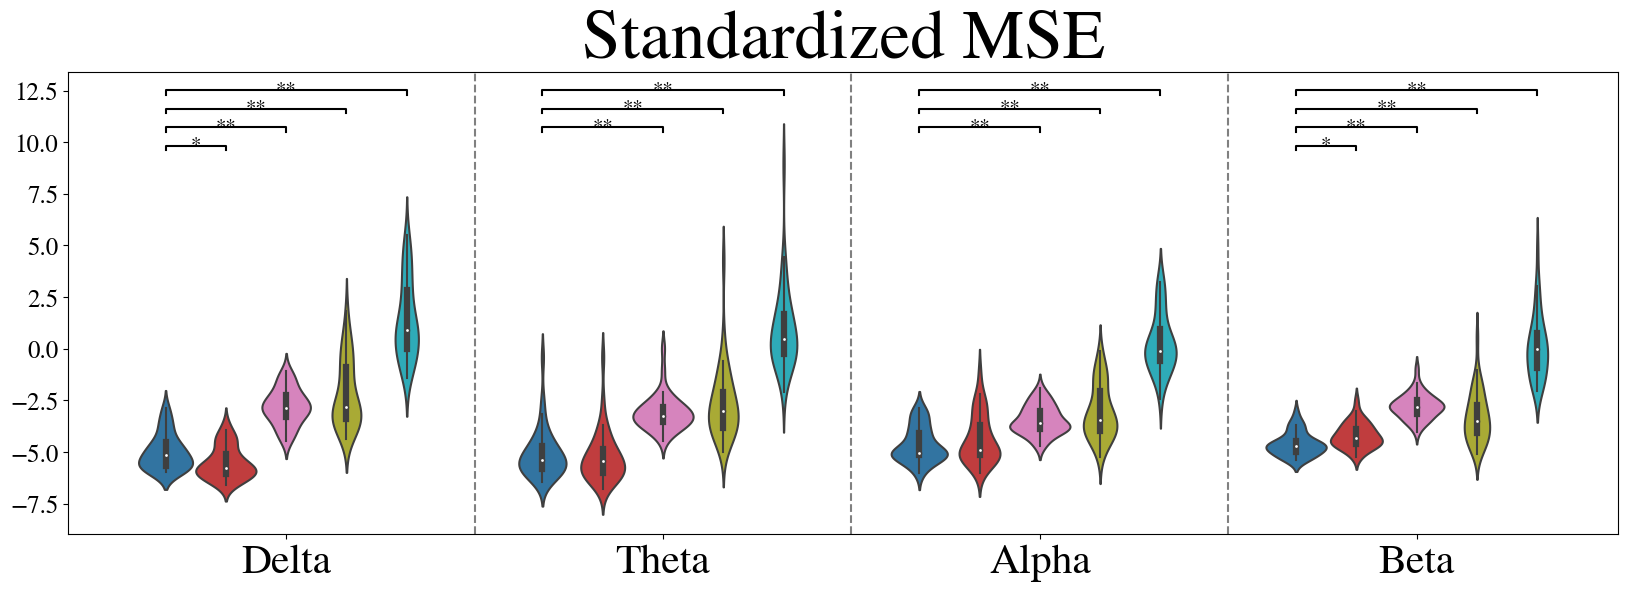

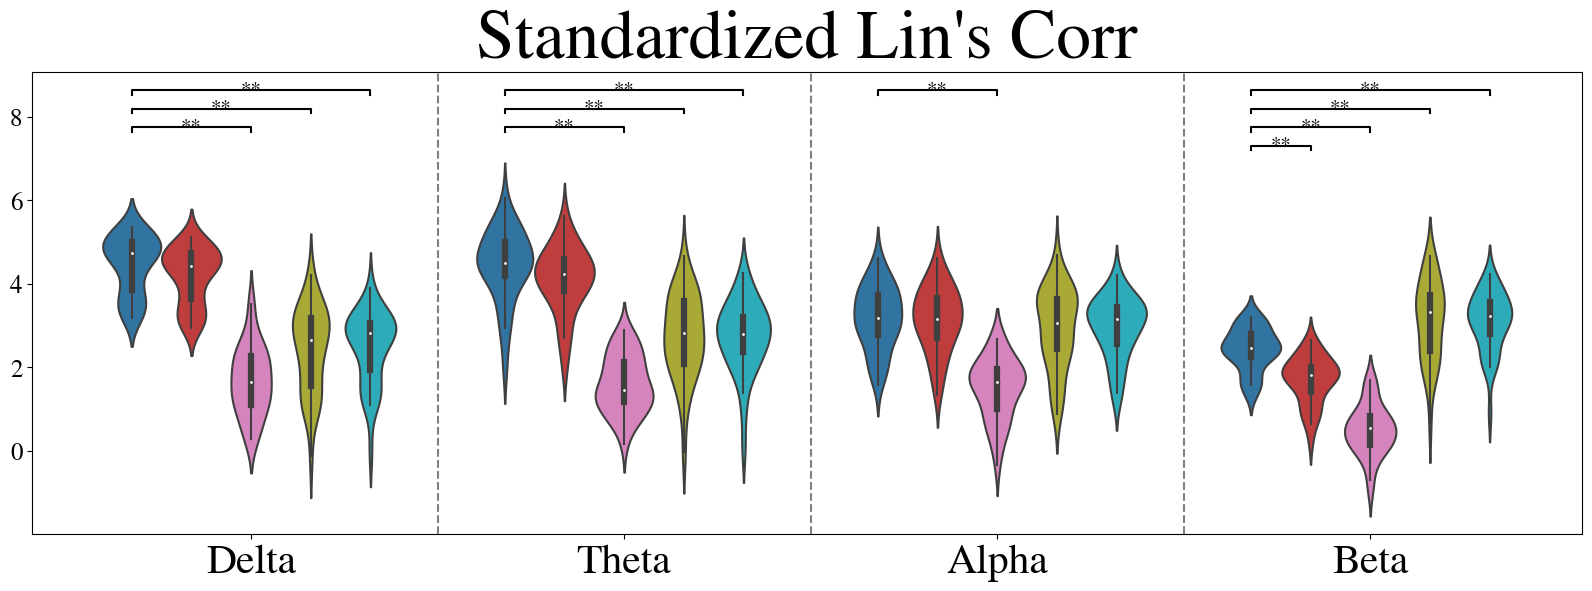

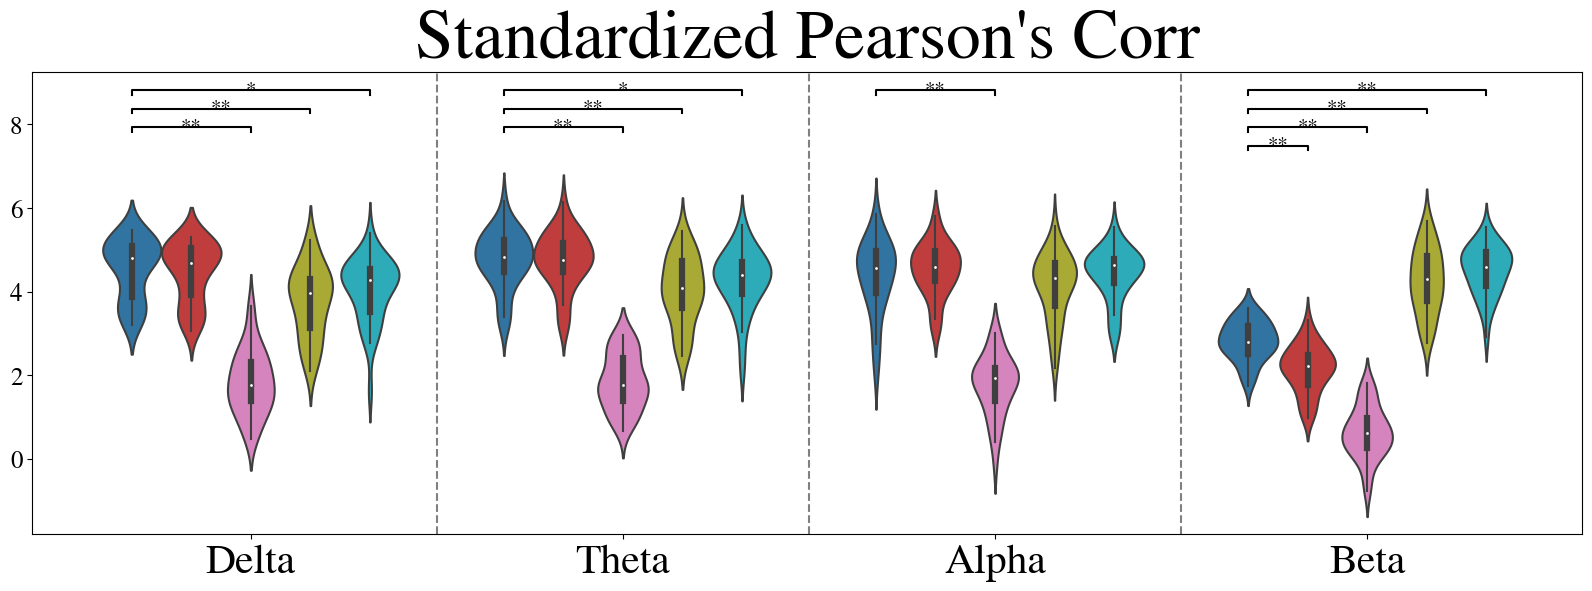

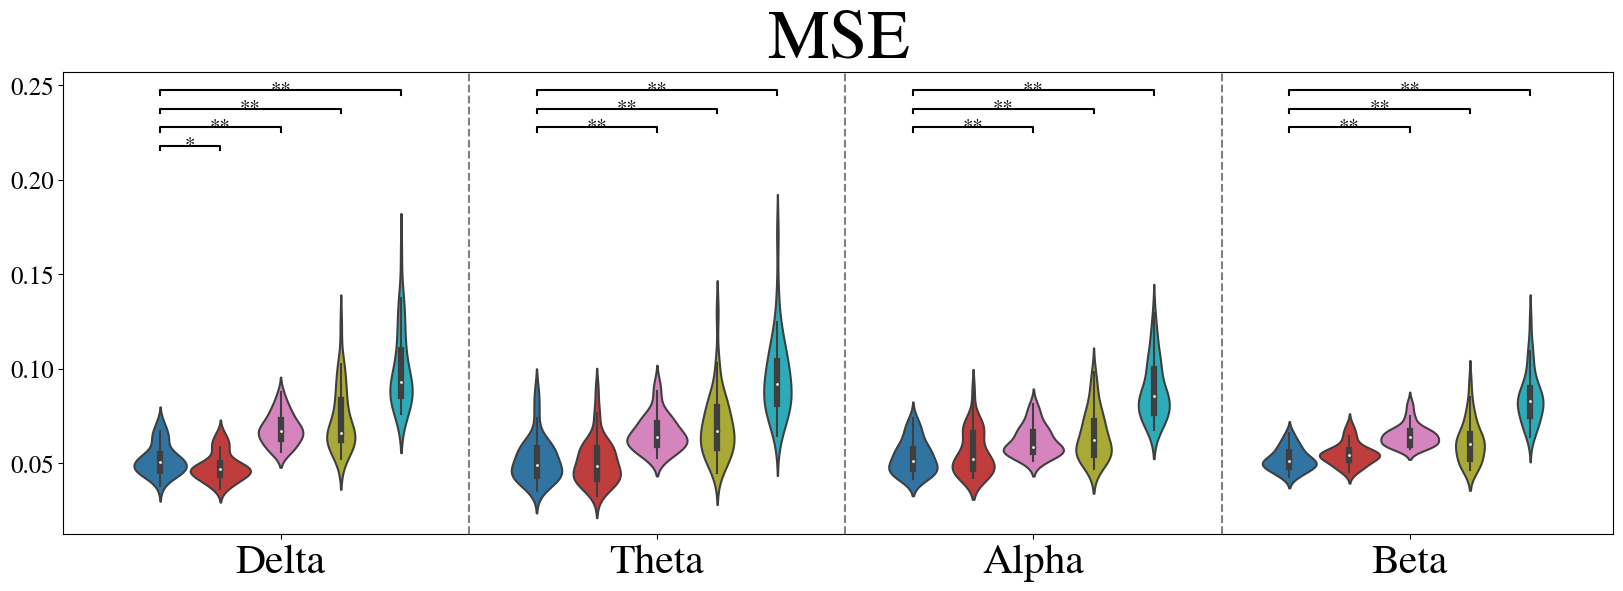

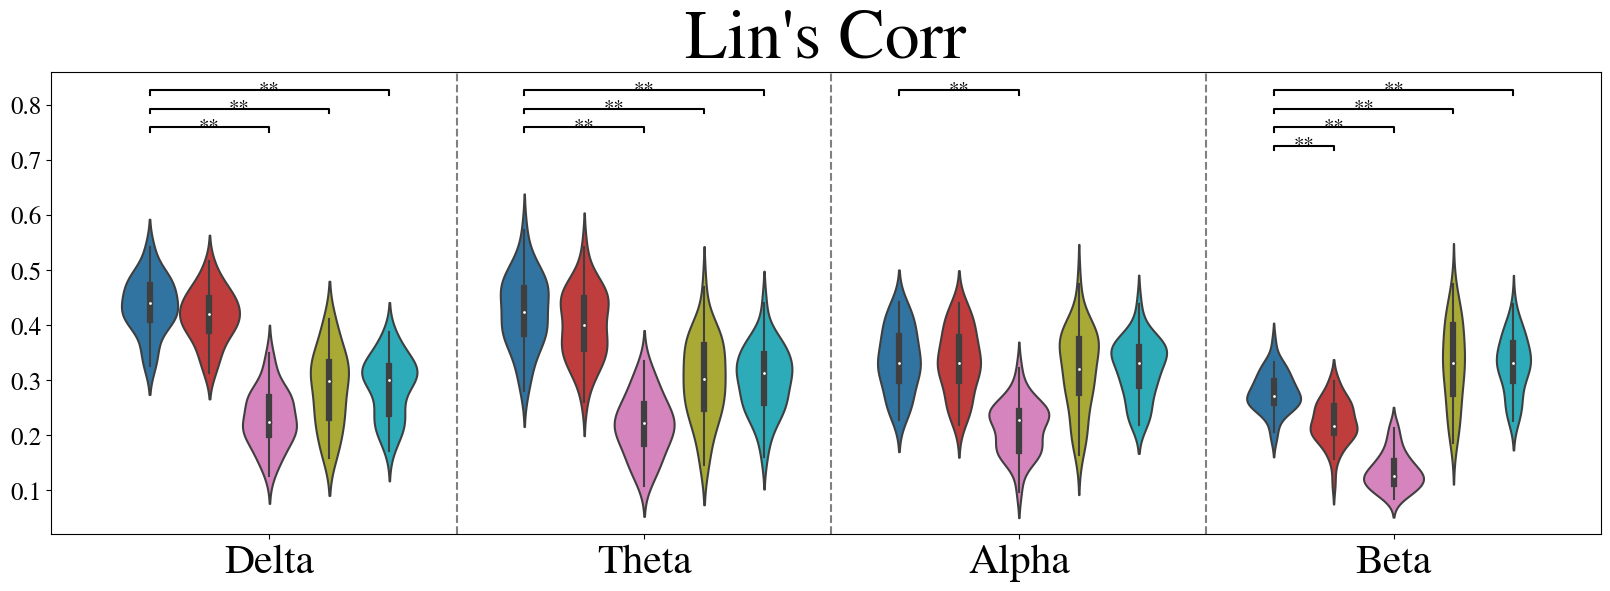

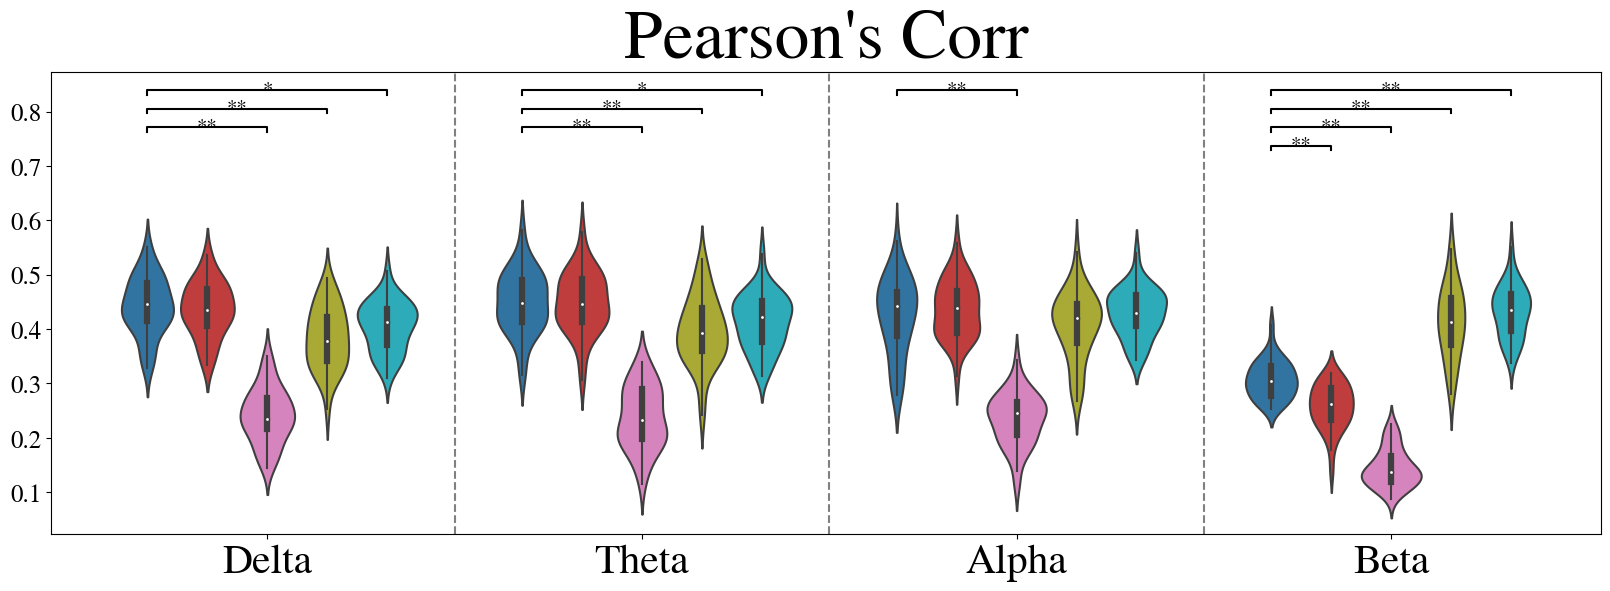

In [41]:
def add_stat_annotation(ax, x1, x2, relative_y, h, text):
    y1 = y_min + relative_y * (y_max - y_min)
    y2 = y1 + h * (y_max - y_min)
    ax.plot([x1, x1, x2, x2], [y1, y2, y2, y1], lw=1.5, color='k')
    ax.text((x1 + x2) * .5, y2, text, ha='center', va='center', color='k')

metrics = ["mse_std", "lin_r_std", "reg_r_std", "mse", "lin_r", "reg_r"]
metric = metrics[0]
method_names0 = [ 
    "SGM-SBI", 
    "SGM-SBI-shared", 
    "NMM",
    "Eigen",
    "Direct"]

for metric in metrics:
    # get the pvals of current metric
    vals = { bd:pval_matss[bd][metric][0] for bd in paras.allbds}
    cdf = pd.DataFrame(vals)
    cdf.index = method_names

    nmethod = len(method_names0)
    plt.figure(figsize=[20, 6])
    plt.title(f"{metric_names_plot[metrics.index(metric)]}", fontsize=50)
    ax = sns.violinplot(x='Band', y=metric, hue="Method", hue_order=method_names0,
                        data=df_plots, split=False, palette=method_cols)
    plt.xlabel("")
    plt.ylabel("")
    plt.ylim(ymax=df_plots[metric].max()*1.5)
    plt.xticks(np.arange(len(paras.allbds)), bands_name, fontsize=30)
    # put the legend alongside the violinplot
    legend = ax.legend_
    legend.remove()

    #plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=5) 

    
    keys = df_plots['Band'].unique()
    for key_idx, key in enumerate(keys):
        if key_idx < len(keys) - 1:
            ax.axvline(x=key_idx + 0.5, color='grey', linestyle='--')


    # add the pval notations to the plot
    y_min, y_max = ax.get_ylim()
    violins = ax.collections
    # the the center x for first
    v1_x =np.mean(violins[0].get_paths()[0].vertices[:, 0])
    violin_gap = np.abs(v1_x)/((nmethod-1)/2)
    left_xs = np.arange(len(keys)) + v1_x
    gaps = np.arange(1, nmethod) * violin_gap
    bar_width = 0.01
    bar_h  = 0.95

    for bandix, left_x in enumerate(left_xs):
        band = paras.allbds[bandix]
        flag = 0
        for idx, gap in enumerate(gaps[::-1]):
            method = method_names0[len(gaps)-idx]
            pval = cdf.loc[method, band]
            pval_label = _pval_fn(pval)
            if pval > 0.05: 
                continue
            add_stat_annotation(ax, left_x, left_x+gap, bar_h-flag*0.04, bar_width, pval_label)
            #add_stat_annotation(ax, left_x, left_x+gap, bar_h-(len(gaps)-flag)*0.04, bar_width, pval_label)
            flag += 1

    plt.savefig(FIG_ROOT/f"revisionR1/{metric}_cmp_results_nolegend.jpg")

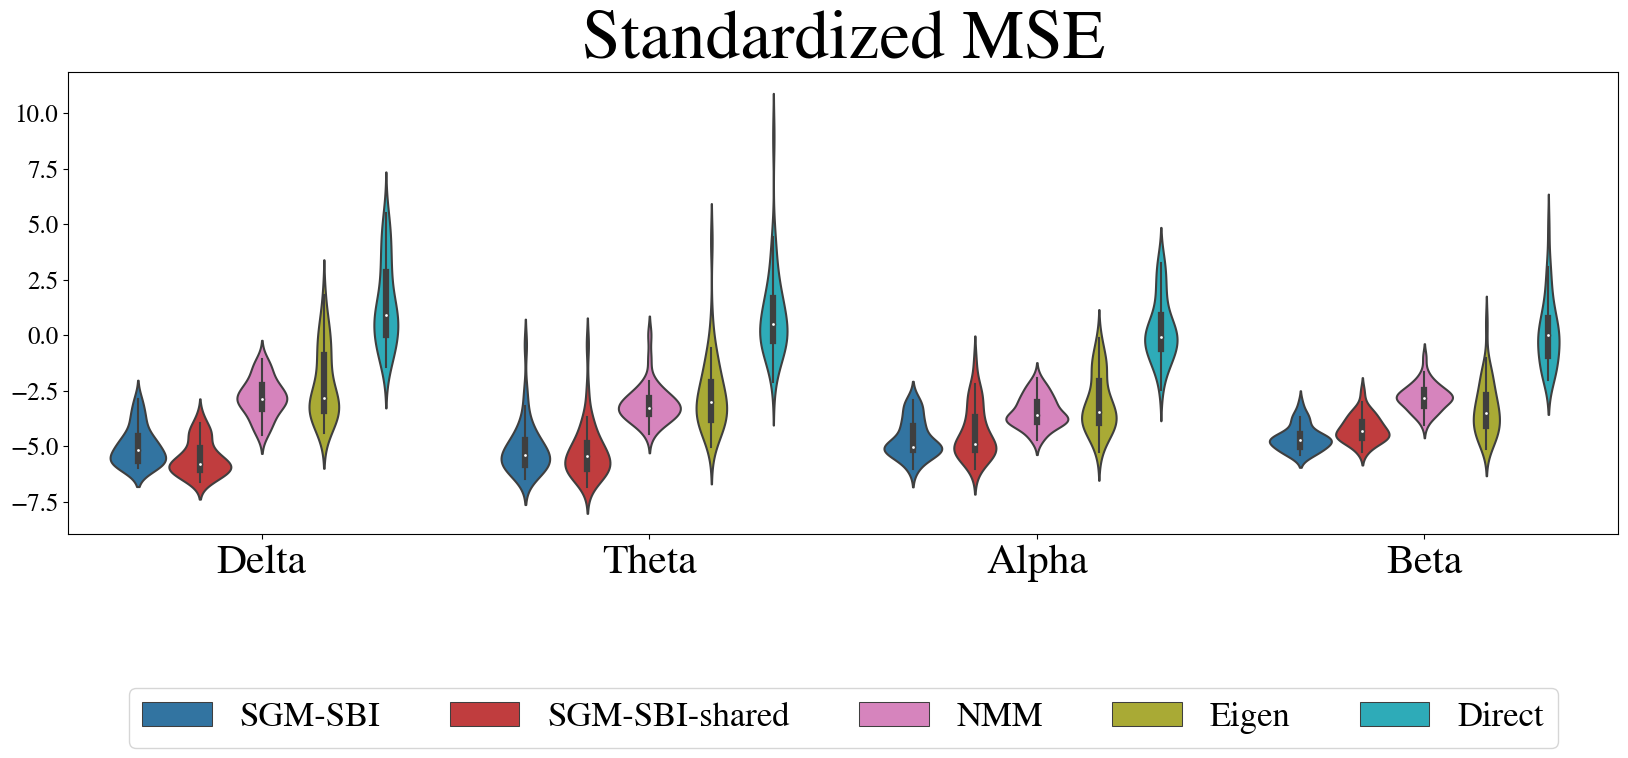

In [43]:
# to get the legend
metric = metrics[0]
plt.figure(figsize=[20, 6])
plt.title(f"{metric_names_plot[metrics.index(metric)]}", fontsize=50)
ax = sns.violinplot(x='Band', y=metric, hue="Method", hue_order=method_names0,
data=df_plots, split=False, palette=method_cols)
plt.xlabel("")
plt.ylabel("")
plt.xticks(np.arange(len(paras.allbds)), bands_name, fontsize=30)
# put the legend alongside the violinplot
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=5) 
    
plt.savefig(FIG_ROOT/f"revisionR1/cmp_results_legend.jpg")

## FC heatmap

In [44]:

band_fc_res = edict()
for band in paras.allbds:
    _trans_fn = lambda fc: _vec_2mat(_minmax_vec(fc[uptri_idxs]))
    sbi_ann_res = load_pkl(RES_ROOT/(f"rawfc2_SBIxANNBW_{band}_"
                                     f"ep{paras.nepoch}_"
                                     f"num1000_densitynsf_MR3_noise_sd120_"
                                     f"addv{paras.add_v*100:.0f}"
                                     f"/inf_res.pkl"), verbose=False);
    sbi_ann_ab_res = load_pkl(RES_ROOT/(f"rawfc2allbd_SBIxANNALLBD_"
                                        f"{'-'.join(paras.allbds)}_"
                                        f"ep{paras.nepoch}_"
                                        f"num1000_densitynsf_MR3_noise_sd120_"
                                        f"addv{paras.add_v*100:.0f}"
                                        f"/inf_res.pkl"), verbose=False);
    empfcs = np.array([_get_fc(sub_ix, band) for sub_ix in range(36)]);
    
    fcss = edict()
    fcss["SGM"] = np.array([_trans_fn(np.abs(est_FC)) 
                                    for est_FC in sbi_ann_res.est_FCs]);
    fcss["SGMAB"]= np.array([_trans_fn(np.abs(est_FC) )
                                         for est_FC in sbi_ann_ab_res[f"est_FCs_{band}"]])
    fcss["SC"] = scs
    fcss["efc"] = np.array([_trans_fn(np.abs(fc)) for fc in empfcs])
    band_fc_res[band] = fcss

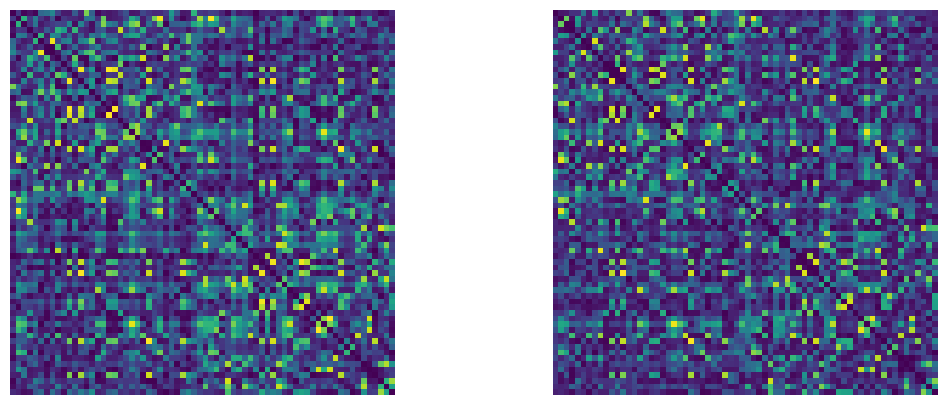

In [56]:
band1 = "delta"
fc1 = band_fc_res[band1]["efc"][6]
band2 = "beta_l"
fc2 = band_fc_res[band2]["efc"][6]

plt.figure(figsize=[12, 5])
plt.subplot(1, 2, 1)
sns.heatmap(fc1, square=True, vmax=1, vmin=0, cbar=False, cmap="viridis")
plt.yticks([])
plt.xticks([]);
plt.subplot(1, 2, 2)
sns.heatmap(fc2, square=True,  vmax=1, vmin=0, cbar=False, cmap="viridis")
plt.yticks([])
plt.xticks([]);



In [57]:
def fc_corr_fn(fc1, fc2):
    idxs = np.triu_indices_from(fc1, k=1);
    vec1 = fc1[idxs]
    vec2 = fc2[idxs]
    return scipy.stats.pearsonr(vec1, vec2)[0]
efcms = []
for band in paras.allbds:
    fcss = band_fc_res[band]    
    efcm = fcss["efc"].mean(axis=0)
    efcms.append(efcm)
    sgmfcm = fcss["SGM"].mean(axis=0)
    sgmabfcm = fcss["SGMAB"].mean(axis=0)
    corrs1 = [fc_corr_fn(fc1, fc2) for fc1, fc2 in zip(fcss["efc"], fcss["SGM"])]
    corrs2 = [fc_corr_fn(fc1, fc2) for fc1, fc2 in zip(fcss["efc"], fcss["SGMAB"])]
    corrs3 = [fc_corr_fn(fc1, fc2) for fc1, fc2 in zip(fcss["SGM"], fcss["SGMAB"])]
    print(band, np.mean(corrs1), np.mean(corrs2), np.mean(corrs3))


delta 0.4424243840592283 0.4361046628113442 0.9836702264590517
theta 0.4499148692621031 0.4487395539826383 0.9895100416734821
alpha 0.42400569775564834 0.4367703003615961 0.9631608814747518
beta_l 0.3071286956966055 0.25751750622530883 0.6667538332771757


In [59]:
for ix in range(4):
    for iy in range(ix+1, 4):
        print(paras.allbds[ix], paras.allbds[iy], fc_corr_fn(efcms[ix], efcms[iy]))

delta theta 0.9864150735919174
delta alpha 0.9711626177463352
delta beta_l 0.9787743345751455
theta alpha 0.9809482703787972
theta beta_l 0.9891837765752073
alpha beta_l 0.9855799846374327


In [29]:
# output FCs
for band in paras.allbds:
    fcss = band_fc_res[band]
    for key in ["efc", "SGM", "SGMAB"]:
        sns.heatmap(fcss[key].mean(axis=0), 
                    square=True, vmax=1, vmin=0, 
                    cbar=False, cmap="viridis")
        plt.yticks([])
        plt.xticks([]);
        plt.savefig(FIG_ROOT/f"FC_{band}_{key}.jpg")
    plt.close()

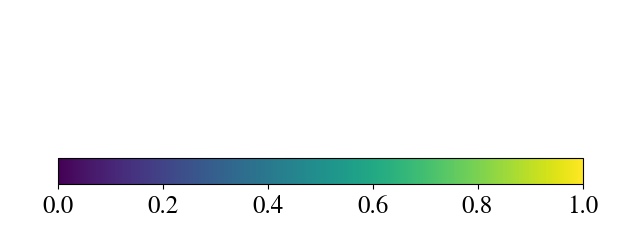

In [153]:
# get colorbar
import matplotlib as mpl

# 创建一个图形和坐标轴
fig, ax = plt.subplots(figsize=(8, 2))
plt.subplots_adjust(top=1)

# 创建一个 ScalarMappable 对象，并设置 colormap（这里使用 'viridis'）
sm = mpl.cm.ScalarMappable(cmap='viridis')
# 这是重要的一步，虽然我们不使用这个对象来绘图
# 我们还需要这样来“激活”我们的 colormap
sm.set_array([])

# 添加 colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')

# 如果需要，可以通过 cbar.set_label 添加标签
#cbar.set_label('My Colorbar Label', size=12)

# 隐藏不需要的坐标轴
ax.axis('off')

plt.savefig(FIG_ROOT/f"FC_colorbar.jpg")

## KDE

In [35]:
from scipy.stats import gaussian_kde
from scipy.signal import savgol_filter
def _kde_plot(vec, prior_bd, label):
    kde = gaussian_kde(vec);
    xrange = np.linspace(prior_bd[0]*0.5,  prior_bd[1]*1.2, 200)
    kde_values = kde(xrange)+1e-2;
    smoothed_kde_values  = np.exp(savgol_filter(np.log(kde_values), window_length=7, polyorder=1))
    smoothed_kde_values = smoothed_kde_values/smoothed_kde_values.mean()/np.diff(prior_bd)
    plt.plot(xrange, smoothed_kde_values, label=label)

names = ["TauC", "Speed", "alpha"]
latex_names = [r"$\tau_G$ (ms)", r"$v$ (m/s)", r"$\alpha$ (a.u.)"]
par_low = np.asarray([0.005, 5, 0.1])
par_high = np.asarray([0.03, 20, 1])
prior_bds = np.array([par_low, par_high]).T;
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=1), prior_bds=prior_bds);

In [ ]:
post_spss = edict()
for band in paras.allbds:
    print(band)
    bw_res_fils = list(RES_ROOT.glob(f"rawfc2_SBIxANNBW_{band}_"
                  f"ep{paras.nepoch}_"
                  f"num1000_densitynsf_MR3_noise_sd120_"
                  f"addv{paras.add_v*100:.0f}"
                  f"/ind*.pkl"))
    bw_res_fils = sorted(bw_res_fils, key=lambda p: int(p.stem.split("ind")[-1]));
    
    
    post_spss[band] = []
    for fil in bw_res_fils:
        res = load_pkl(fil, verbose=False);
        sps = res.sample((1000, ));
        post_sps = _theta_raw_2out(sps.numpy());
        post_spss[band].append(post_sps)

In [ ]:
post_spss["allbd"] = []
ab_res_fils = list(RES_ROOT.glob(f"rawfc2allbd_SBIxANNALLBD_"
                                 f"{'-'.join(paras.allbds)}_"
                                 f"ep{paras.nepoch}_"
                                 f"num1000_densitynsf_MR3_noise_sd120_"
                                 f"addv{paras.add_v*100:.0f}"
                                 f"/ind*.pkl"))
ab_res_fils = sorted(ab_res_fils, key=lambda p: int(p.stem.split("ind")[-1]));
for fil in ab_res_fils:
    res = load_pkl(fil, verbose=False);
    sps = res.sample((1000, ));
    post_sps = _theta_raw_2out(sps.numpy());
    post_spss["allbd"].append(post_sps)

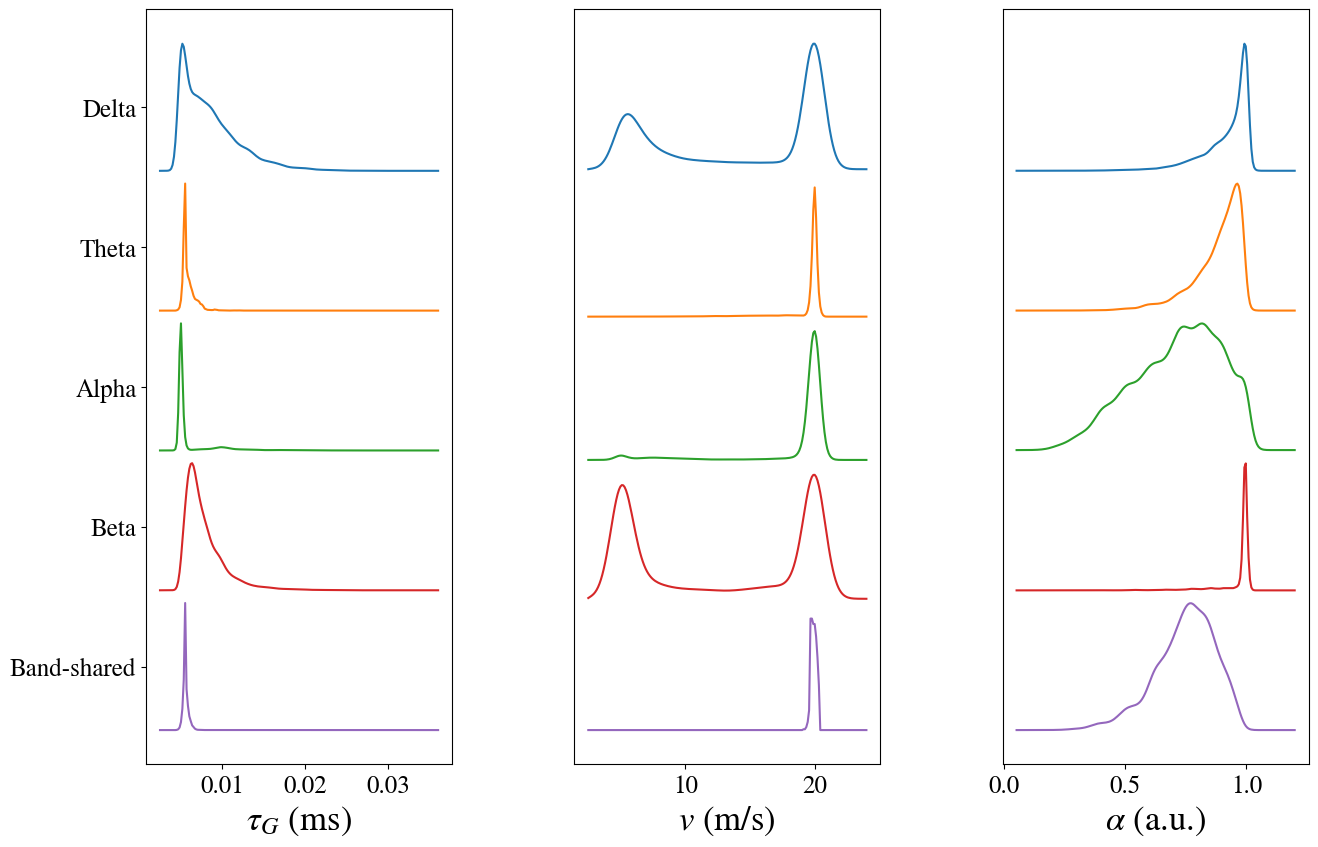

In [50]:
bd_names = ["delta", "theta", "alpha", "beta_l", "allbd"]
bd_names_plot = ["Delta", "Theta", "Alpha", "Beta", "Band-shared"]
_prefn = lambda x: np.array(x).reshape(-1, 3)

intv = 1.1
plt.figure(figsize=[15, 10])
for para_idx in [0, 1, 2]:
    prior_bd = prior_bds[para_idx]
    xrange = np.linspace(prior_bd[0]*0.5,  prior_bd[1]*1.2, 200)
    
    plt.subplot(1, 3, para_idx+1)
    for ix, cur_bd in enumerate(bd_names):
        cur_data = _prefn(post_spss[cur_bd]);
        vec = cur_data[:, para_idx]
        kde = gaussian_kde(vec);
        kde_values = kde(xrange)+1e-2;
        smoothed_kde_values  = np.exp(savgol_filter(np.log(kde_values), window_length=7, polyorder=1))
        kde_values_norm = smoothed_kde_values/smoothed_kde_values.max();
        plt.plot(xrange, kde_values_norm+(len(bd_names)-ix-1)*intv)
    ytick_locs = 0.5+np.arange(0, 5)*intv
    if para_idx == 0:
        plt.yticks(ytick_locs, bd_names_plot[::-1])
    else:
        plt.yticks([])
    plt.xlabel(latex_names[para_idx])
plt.savefig(FIG_ROOT/f"norm_KDE.jpg")

## Eig curve with exp curve

In [31]:
_paras = edict()
_paras.delta = [2, 3.5]
_paras.theta = [4, 7]
_paras.alpha = [8, 12]
_paras.beta_l = [13, 20]

In [42]:
from forward import network_transfer_macrostable as nt

par_low = np.asarray([0.005, 5, 0.1])
par_high = np.asarray([0.03, 20, 1])
prior_bds = np.array([par_low, par_high]).T;
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=1), prior_bds=prior_bds);

def _get_lam(raw_params, brain, freq):
    params = _theta_raw_2out(raw_params)
    
    params_dict = dict()
    params_dict["tauC"] =  params[0]
    params_dict["speed"] =  params[1]
    params_dict["alpha"] =  params[2]
    _, U, flam, lam = nt.network_transfer_local_fc_alpha(brain , params_dict, freq, is_full=True)
    return U[:68, :68], flam[:68], lam[:68]

brains = []
for cur_ind_idx in range(36):
    brain = Brain.Brain()
    brain.add_connectome(DATA_ROOT) # grabs distance matrix
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.connectome =  _add_v2con(ind_conn[:, :, cur_ind_idx], paras.add_v)
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    brains.append(brain)

In [34]:
band_fc_res = edict()
for band in paras.allbds:
    _trans_fn = lambda fc: _vec_2mat(_minmax_vec(fc[uptri_idxs]))
    sbi_ann_res = load_pkl(RES_ROOT/(f"rawfc2_SBIxANNBW_{band}_"
                                     f"ep{paras.nepoch}_"
                                     f"num1000_densitynsf_MR3_noise_sd120_"
                                     f"addv{paras.add_v*100:.0f}"
                                     f"/inf_res.pkl"), verbose=False);
    sbi_ann_ab_res = load_pkl(RES_ROOT/(f"rawfc2allbd_SBIxANNALLBD_"
                                        f"{'-'.join(paras.allbds)}_"
                                        f"ep{paras.nepoch}_"
                                        f"num1000_densitynsf_MR3_noise_sd120_"
                                        f"addv{paras.add_v*100:.0f}"
                                        f"/inf_res.pkl"), verbose=False);
    empfcs = np.array([_get_fc(sub_ix, band) for sub_ix in range(36)]);
    
    fcss = edict()
    fcss["SGM"] = np.array([np.abs(est_FC) for est_FC in sbi_ann_res.est_FCs]);
    fcss["SGMAB"]= np.array([np.abs(est_FC) for est_FC in sbi_ann_ab_res[f"est_FCs_{band}"]])
    fcss["SC"] = scs
    fcss["efc"] = np.array([np.abs(fc) for fc in empfcs])
    band_fc_res[band] = fcss

In [ ]:
post_spss = edict()
for band in paras.allbds:
    print(band)
    bw_res_fils = list(RES_ROOT.glob(f"rawfc2_SBIxANNBW_{band}_"
                  f"ep{paras.nepoch}_"
                  f"num1000_densitynsf_MR3_noise_sd120_"
                  f"addv{paras.add_v*100:.0f}"
                  f"/ind*.pkl"))
    bw_res_fils = sorted(bw_res_fils, key=lambda p: int(p.stem.split("ind")[-1]));
    
    
    post_spss[band] = []
    for fil in bw_res_fils:
        res = load_pkl(fil, verbose=False);
        sps = res.sample((1000, ));
        post_sps = _theta_raw_2out(sps.numpy());
        post_spss[band].append(post_sps)

In [194]:
from sklearn.linear_model import LinearRegression

#if True:
def _get_expfit(xs, ys):
    if not isinstance(xs, np.ndarray):
        xs = np.array(xs)
    if not isinstance(ys, np.ndarray):
        ys = np.array(ys)
    xso = xs.copy()
    ys = ys.mean(axis=0)
    xs = xs.mean(axis=0)

    cutoff = np.quantile(ys, 0.05)
    ys[ys<cutoff] = cutoff
    kpidx = np.bitwise_and(ys > cutoff, xs< 0.6)

    fit_logy = np.log(ys[kpidx])
    fit_x = xs[kpidx].reshape(-1, 1)
    fit = LinearRegression().fit(fit_x, fit_logy)

    xrange = np.linspace(xso.min(), xso.max(), 100)
    pred_y = np.exp(fit.predict(xrange.reshape(-1, 1)));
    return xrange, pred_y, fit

def _get_expcurv(xs, ys):
    xrange, pred_y, fit = _get_expfit(xs, ys)
    fml = f"log(y)={fit.coef_[0]:.3f}x+{fit.intercept_:.3f}"
    plt.annotate(fml, xy=(xrange[0], pred_y[0]), xytext=(0.2, 0.95),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5, headlength=10),  
                #xycoords='axes fraction',
                textcoords='axes fraction')
    plt.plot(xrange, pred_y, color="black", linewidth=3, ls="--")

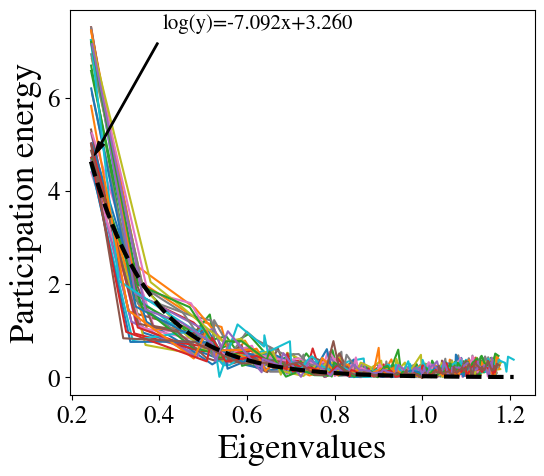

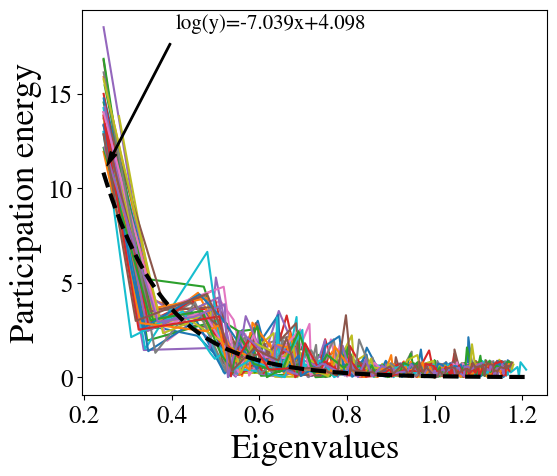

In [200]:
band = "beta_l"
band_name = "Alpha" # it is in fact not used
flams = []
lams = []
empFC_UFU_diags = []
estFC_UFU_diags = []
Us = []

for sub_idx in range(36):
    mid_pt = np.mean(_paras[band])
    raw_params = np.mean(np.array(post_spss[band]), axis=1)[sub_idx, :]
    U, flam, lam = _get_lam(raw_params, brains[sub_idx],  mid_pt);
    lam = np.abs(lam)
    estFC = band_fc_res[band]["SGM"][sub_idx];
    estFC_UFU = np.abs(np.matrix.getH(U) @ estFC @ U);
    estFC_UFU_diag = np.diag(estFC_UFU);
    
    empFC = band_fc_res[band]["efc"][sub_idx]
    empFC_UFU = np.abs(np.matrix.getH(U) @ empFC @ U)
    empFC_UFU_diag = np.diag(empFC_UFU)
    
    lams.append(lam)
    flams.append(flam)
    empFC_UFU_diags.append(empFC_UFU_diag)
    estFC_UFU_diags.append(estFC_UFU_diag)
    Us.append(U)
    
#plt.suptitle(f"{band_name} band", fontsize=20)
plt.figure(figsize=[6, 5])
xs, ys = lams, estFC_UFU_diags
for sub_idx in range(36):
    plt.plot(xs[sub_idx], ys[sub_idx])
    #plt.ylabel(r"$f_{\rm SGM}(\lambda)$")
    #plt.xlabel(r"$\lambda$")
    plt.ylabel("Participation energy")
    plt.xlabel("Eigenvalues")
_get_expcurv(xs, ys)
plt.savefig(FIG_ROOT/f"revisionR1/lambda_plot_{band}_SGM.jpg")
    
plt.figure(figsize=[6, 5])
xs, ys = lams, empFC_UFU_diags
for sub_idx in range(36):
    plt.plot(lams[sub_idx], empFC_UFU_diags[sub_idx])
    plt.ylabel("Participation energy")
    plt.xlabel("Eigenvalues")
    #plt.ylabel(r"$f_{\rm emp}(\lambda)$")
    #plt.xlabel(r"$\lambda$")
_get_expcurv(xs, ys)
plt.savefig(FIG_ROOT/f"revisionR1/lambda_plot_{band}_MEG.jpg")

In [34]:
band = "beta_l"
flams = []
lams = []
empFC_UFU_diags = []
estFC_UFU_diags = []
Us = []

for sub_idx in range(36):
    mid_pt = np.mean(_paras[band])
    raw_params = np.mean(np.array(post_spss[band]), axis=1)[sub_idx, :]
    U, flam, lam = _get_lam(raw_params, brains[sub_idx],  mid_pt);
    lam = np.abs(lam)
    estFC = band_fc_res[band]["SGM"][sub_idx];
    estFC_UFU = np.abs(np.matrix.getH(U) @ estFC @ U);
    estFC_UFU_diag = np.diag(estFC_UFU);
    
    empFC = band_fc_res[band]["efc"][sub_idx]
    empFC_UFU = np.abs(np.matrix.getH(U) @ empFC @ U)
    empFC_UFU_diag = np.diag(empFC_UFU)
    
    lams.append(lam)
    flams.append(flam)
    empFC_UFU_diags.append(empFC_UFU_diag)
    estFC_UFU_diags.append(estFC_UFU_diag)
    Us.append(U)
corrs = []
for sub_idx in range(36):
    vec1 = estFC_UFU_diags[sub_idx]
    vec2 = empFC_UFU_diags[sub_idx]
    corrs.append(scipy.stats.pearsonr(vec1, vec2)[0])
print(band, np.mean(corrs))

beta_l 0.9636411107029887


## Brain plot

In [39]:
org_ord = np.loadtxt(DATA_ROOT/"rois_order.txt", dtype=str)
org_ord = np.array([".".join([roi.split("_")[1].lower(), roi.split("_")[0].lower()]) for roi in org_ord][:68])
target_ord = np.loadtxt(DATA_ROOT/"dk68_utils/ROI_order_DK68.txt", dtype=str);
order_idxs = np.where(target_ord.reshape(-1, 1)== org_ord.reshape(1, -1))[-1];
# if a vec is from org_ord, then vec[order_idxs] is with target_ord

In [40]:
from nilearn import plotting
from utils.brain_plot import get_bg_data
import matplotlib as mpl
def _brain_plot(vec, cmap="Reds", threshold=None, vbds=None):
    root = DATA_ROOT/"dk68_utils/"
    h = 0.6
    
    XYZsl = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_XYZs_left.txt")
    facesl = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_faces_left.txt").astype(np.int64)
    roi_tmpl = np.loadtxt(root/"brain_tmp_left_DK68.txt");
    bg_datal = get_bg_data(XYZsl, facesl)
    
    XYZsr = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_XYZs_right.txt")
    facesr = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_faces_right.txt").astype(np.int64)
    roi_tmpr = np.loadtxt(root/"brain_tmp_right_DK68.txt");
    bg_datar = get_bg_data(XYZsr, facesr)
    
    # map vec to the template
    vecl = roi_tmpl.copy()
    vecr = roi_tmpr.copy()
    for roi_ix in range(1, 35):
        vecl[roi_tmpl==roi_ix] = vec[roi_ix-1]
        vecr[roi_tmpr==roi_ix] = vec[roi_ix-1+34]
        
    if vbds is not None:
        vmin, vmax = vbds
    else:
        vmin, vmax = np.min(vec), np.max(vec)
    #fig, axs = plt.subplots(2, 2, figsize=[10, 10], subplot_kw={'projection': '3d'})
    fig = plt.figure(figsize=(10, 6))
    # left, bottom, width, height
    # facecolor make the bg  transparent
    ax1 = fig.add_axes([0.1,  0.5, h,  h], projection='3d',  facecolor='none')
    ax2 = fig.add_axes([0.15, 0.1, h,  h], projection='3d',  facecolor='none') 
    ax3 = fig.add_axes([0.5,  0.5, h,  h], projection='3d',  facecolor='none')
    ax4 = fig.add_axes([0.47, 0.1, h,  h], projection='3d',  facecolor='none')  
    
    plotting.plot_surf_roi([XYZsl, facesl], vecl, hemi='left', view="lateral", axes=ax1, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datal, # TO get the depth of the brain plot
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsl, facesl], vecl, hemi='left', view="medial", axes=ax2, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datal,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsr, facesr], vecr, hemi='right', view="lateral", axes=ax3, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datar,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsr, facesr], vecr, hemi='right', view="medial", axes=ax4, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datar,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    
    #fig.text(0.22, 0.36, 'Medial', ha='center', va='center')
    #fig.text(0.22, 0.78, 'Lateral', ha='center', va='center')
    #fig.text(0.24, 0.97, 'Left', ha='center', va='center')
    #fig.text(0.92, 0.97, 'Right', ha='center', va='center')
    #plt.suptitle("-log pvalues", fontsize=30)
    
    #norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    #sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    #sm.set_array([])  
    #cbar_ax = fig.add_axes([.91, .3, .03, .4])
    #fig.colorbar(sm, cax=cbar_ax)
    return fig

In [45]:
band_names = ["Delta", "Theta", "Alpha", "Beta"]
U_res = edict()
for bidx, band in enumerate(paras.allbds):
    lams = []
    empFC_UFU_diags = []
    Us = []
    
    for sub_idx in range(36):
        mid_pt = np.mean(_paras[band])
        raw_params = np.mean(np.array(post_spss[band]), axis=1)[sub_idx, :]
        U, flam, lam = _get_lam(raw_params, brains[sub_idx],  mid_pt);
        lam = np.abs(lam)
        
        empFC = band_fc_res[band]["efc"][sub_idx]
        empFC_UFU = np.abs(np.matrix.getH(U) @ empFC @ U)
        empFC_UFU_diag = np.diag(empFC_UFU)
        
        lams.append(lam)
        empFC_UFU_diags.append(empFC_UFU_diag)
        Us.append(U)
        
    mlam = np.mean(lams, axis=0)
    mdiag = np.mean(empFC_UFU_diags, axis=0)
    idxp1 = np.argsort(mlam)[:2]
    idxp2 = np.where(np.diff(mdiag[np.argsort(mlam)])>0)[0][0]+1
    idxs = np.concatenate([idxp1, [idxp2]])
    U_res[band_names[bidx]] = (np.array(Us), idxs)

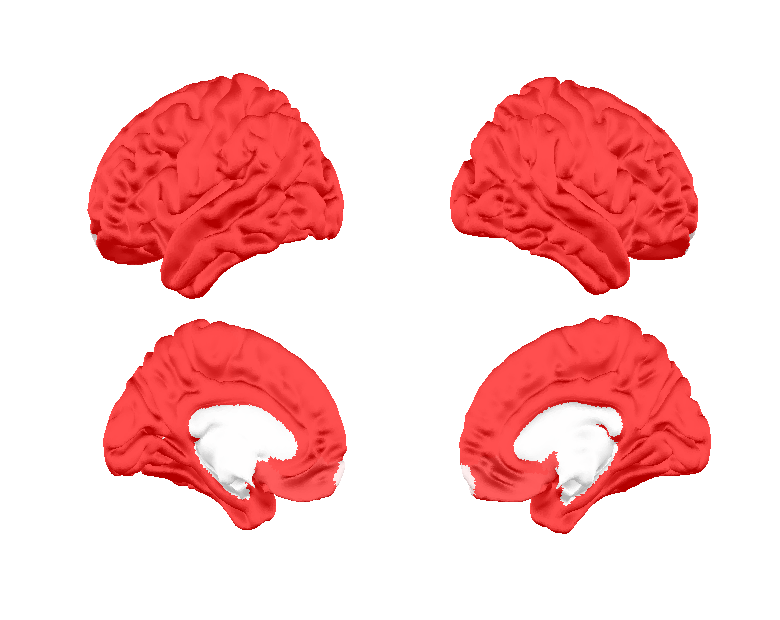

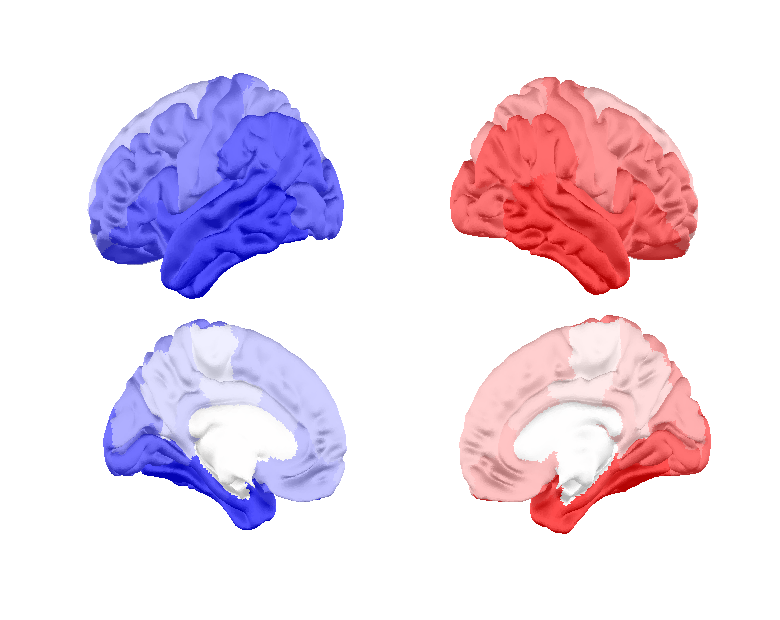

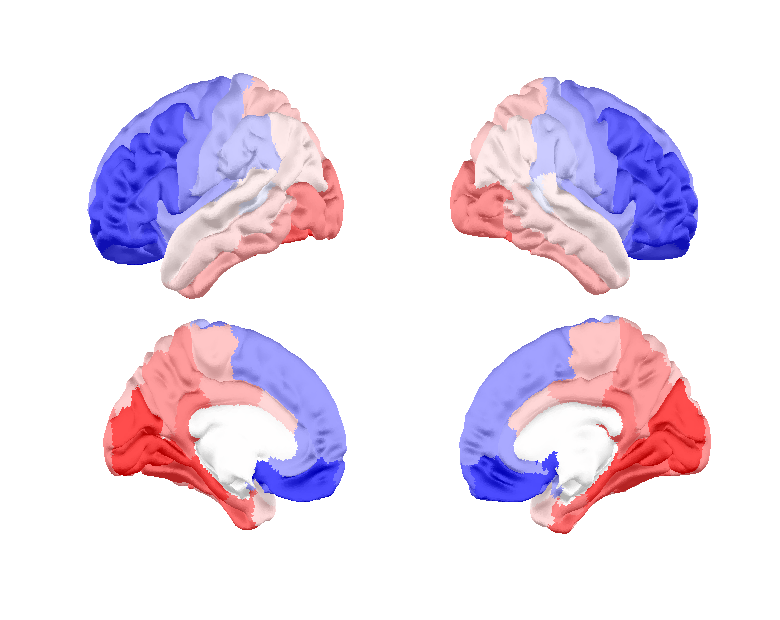

In [46]:
cmap = "bwr"
band_name = "Alpha"
Us = U_res[band_name][0]
for U_idx in U_res[band_name][1]:
    cvec = Us[:, :, U_idx].mean(axis=0)
    rvec = cvec.real
    rvec = _pn_minmax(rvec)
    fig = _brain_plot(rvec[order_idxs], cmap=cmap, vbds=[-1, 1]);
    fig.savefig(FIG_ROOT/f"revisionR1/real_U{U_idx}_{band_name}.jpg")

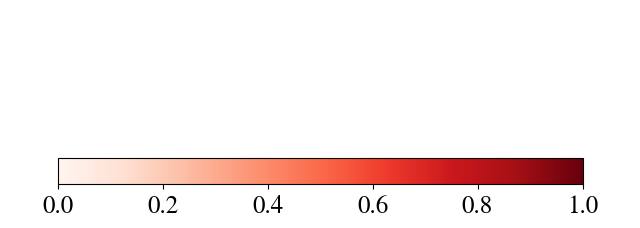

In [200]:
import matplotlib as mpl
vmin, vmax = -1, 1
cmap = "bwr"

fig, ax = plt.subplots(figsize=(8, 2))
plt.subplots_adjust(top=1)

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
ax.axis('off')

plt.savefig(FIG_ROOT/f"revisionR1/brain_{cmap}_colorbar.jpg")